In [7]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [23]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import ActivityNetCap2Instances, CharadesSTA2Instances
from src.toolbox.baseline import SegmentGeneratorKDE
import seaborn as sns
sns.set()
import json
import pickle as pkl

# Comaprison on Charade-STA

In [37]:
test_data = Charade2Instances(pd.read_csv('data/processed/test.csv'))

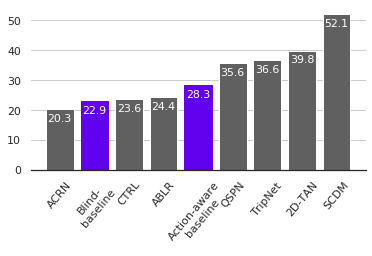

In [81]:
leaderboard = {}
leaderboard["Blind-\nbaseline"] = 22.88
leaderboard["Action-aware\nbaseline"] = 28.28
leaderboard.update({
    "CTRL": 23.63,
    "ACRN": 20.26,
    "QSPN": 35.60,
    "ABLR": 24.36,
    "TripNet": 36.61,
    "2D-TAN": 39.81,
#     "2D-TAN\n(random)": 36.69,
#     "2D-TAN\n(shuffle)": 38.31,
#     "SCDM\n(shuffle)": 24.23,
    "SCDM": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
})

labels = list(leaderboard.keys())
scores = list(leaderboard.values())
sorted_idx = np.argsort(scores)
scores = [scores[i] for i in sorted_idx]
labels = [labels[i] for i in sorted_idx]
n = len(sorted_idx)

sns.set_style("white")
plt.figure(figsize=(6, 3))
bars = plt.bar(np.arange(n), scores, color="#606060", width=0.8)
plt.xticks(np.arange(n), labels=labels, rotation=50)

bars[1].set_color("#6002ee")
bars[4].set_color("#6002ee")

def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-4,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=11,
        color=color
    )

for i, b in enumerate(bars):
    if i in [1, 4]:
        f_color = "w"
    else:
        f_color = "w"
    display_score(b, color=f_color)
        

plt.gca().yaxis.grid()
sns.despine(left=True)
plt.savefig("reports/figures/performance_comparison/performance_charade-STA.pdf", bbox_inches="tight")

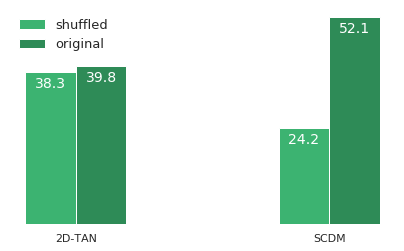

In [19]:
charade_scores = {
"2D-TAN": 39.81,
"2D-TAN\n(random)": 36.69,
"2D-TAN\n(shuffle)": 38.31,
"SCDM\n(shuffle)": 24.23,
"SCDM": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
}

x_pos = np.asarray([0, 1])
step = .2
width = .2

sns.set_style("white")
plt.figure(figsize=(7, 4))
bars = plt.bar(x_pos,
        [charade_scores["2D-TAN\n(shuffle)"], charade_scores["SCDM\n(shuffle)"]],
        color="mediumseagreen",
        width=width,
        label="shuffled"
       )

for b in bars:
    plt.text(
        b.get_x()+width*.5,
        b.get_height()-4,
        f"{b.get_height():.1f}",
        horizontalalignment="center",
        color="w"
    )
    
bars = plt.bar(x_pos+step,
        [charade_scores["2D-TAN"], charade_scores["SCDM"]],
        color="seagreen",
        width=width,
        label="original"
       )

for b in bars:
    plt.text(
        b.get_x()+width*.5,
        b.get_height()-4,
        f"{b.get_height():.1f}",
        horizontalalignment="center",
        color="w"
    )
    
plt.xticks(x_pos+step*.5, ["2D-TAN", "SCDM"])
plt.legend(frameon=False, fontsize=13)
plt.gca().get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True)
plt.savefig("reports/figures/performance_comparison/sanity_check_chrade.pdf", bbox_inches="tight")

In [112]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/random/Charades/TAN_vgg_rgb_test.pkl", "rb"))
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".")
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

R@1 IoU>0.3 0.49
R@1 IoU>0.5 0.37
R@1 IoU>0.7 0.19
R@5 IoU>0.3 0.88
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.47
R@10 IoU>0.3 0.88
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.47


In [111]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/shuffle/Charades/TAN_vgg_rgb_test.pkl", "rb"))
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".")
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.53
R@1 IoU>0.5 0.38
R@1 IoU>0.7 0.20
R@5 IoU>0.3 0.91
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.47
R@10 IoU>0.3 0.91
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.47


'38.31'

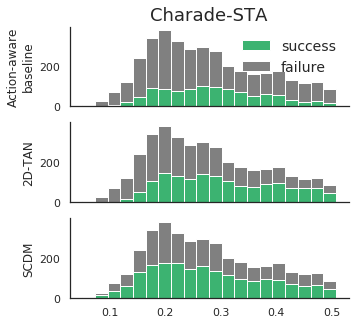

In [41]:
sns.set_style("white")
plt.rcParams.update({'font.size': 14})
f, axes = plt.subplots(3, 1, sharey=True, figsize=(5, 5))

results = pkl.load(open("reports/figure_src/results/charade/blind(action).pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[0])
xlim = axes[0].get_xlim()
axes[0].set_ylabel("Action-aware\nbaseline")
axes[0].set_xticks([])
axes[0].set_title("Charade-STA", fontsize=18)

results = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[1])
axes[1].set_ylabel("2D-TAN")
axes[1].set_xlim(xlim)
axes[1].set_xticks([])
axes[1].get_legend().remove()

results = pkl.load(open("reports/figure_src/results/charade/scdm.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[2])
axes[2].set_ylabel("SCDM")
axes[2].set_xlim(xlim)
axes[2].get_legend().remove()

sns.despine()
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_duration/blind-action_2d-tan_scdm.pdf", bbox_inches="tight")

# Comaprison on ActivityNet captions

In [26]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [114]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/shuffle/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.62


'43.68'

In [118]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.59
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.62


'44.05'

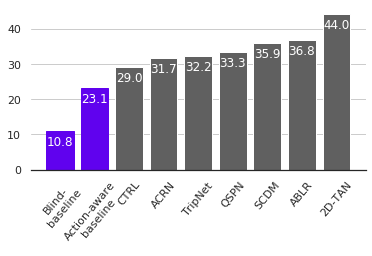

In [82]:
leaderboard = {}
leaderboard["Blind-\nbaseline"] = 10.83
leaderboard["Action-aware\nbaseline"] = 23.14
leaderboard.update({
    "CTRL": 29.01,
    "ACRN": 31.67,
    "QSPN": 33.26,
    "ABLR": 36.79,
    "TripNet": 32.19,
    "2D-TAN": 44.05,
#     "2D-TAN\n(random)": 36.69,
#     "2D-TAN\n(shuffle)": 43.68,
    "SCDM": 35.86 # https://arxiv.org/pdf/1910.14303.pdf
})

labels = list(leaderboard.keys())
scores = list(leaderboard.values())
sorted_idx = np.argsort(scores)
scores = [scores[i] for i in sorted_idx]
labels = [labels[i] for i in sorted_idx]
n = len(sorted_idx)

sns.set_style("white")
plt.figure(figsize=(6, 3))
bars = plt.bar(np.arange(n), scores, color="#606060", width=0.8)
plt.xticks(np.arange(n), labels=labels, rotation=50)

bars[0].set_color("#6002ee")
bars[1].set_color("#6002ee")

def display_score(bar):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-4,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color="w"
    )

for b in bars:
    display_score(b)

plt.gca().yaxis.grid()
sns.despine(left=True)
plt.savefig("reports/figures/performance_comparison/performance_ActivityNetCap.pdf", bbox_inches="tight")

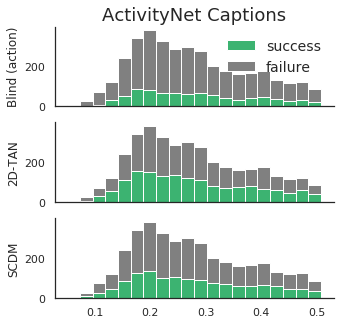

In [43]:
sns.set_style("white")
plt.rcParams.update({'font.size': 14})
f, axes = plt.subplots(3, 1, sharey=True, figsize=(5, 5))
data_name = "activitynet"

results = pkl.load(open(f"reports/figure_src/results/{data_name}/blind(action).pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[0])
xlim = axes[0].get_xlim()
axes[0].set_ylabel("Blind (action)")
axes[0].set_xticks([])
axes[0].set_title("ActivityNet Captions", fontsize=18)

results = pkl.load(open(f"reports/figure_src/results/{data_name}/2d-tan.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[1])
axes[1].set_ylabel("2D-TAN")
axes[1].set_xlim(xlim)
axes[1].set_xticks([])
axes[1].get_legend().remove()

results = pkl.load(open(f"reports/figure_src/results/{data_name}/scdm.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[2])
axes[2].set_ylabel("SCDM")
axes[2].set_xlim(xlim)
axes[2].get_legend().remove()

sns.despine()
plt.savefig(f"reports/figures/detailed_analysis/{data_name}/performance_per_duration/blind-action_2d-tan_scdm.pdf", bbox_inches="tight")

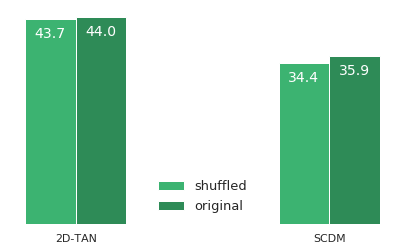

In [20]:
activitynet_score = {
"2D-TAN": 44.05,
"2D-TAN\n(shuffle)": 43.68,
"SCDM\n(shuffle)": 34.36,
"SCDM": 35.86, # https://arxiv.org/pdf/1910.14303.pdf
}

x_pos = np.asarray([0, 1])
step = .2
width = .2

sns.set_style("white")
plt.figure(figsize=(7, 4))
bars = plt.bar(x_pos,
        [activitynet_score["2D-TAN\n(shuffle)"], activitynet_score["SCDM\n(shuffle)"]],
        color="mediumseagreen",
        width=width,
        label="shuffled"
       )

for b in bars:
    plt.text(
        b.get_x()+width*.5,
        b.get_height()-4,
        f"{b.get_height():.1f}",
        horizontalalignment="center",
        color="w"
    )
    
bars = plt.bar(x_pos+step,
        [activitynet_score["2D-TAN"], activitynet_score["SCDM"]],
        color="seagreen",
        width=width,
        label="original"
       )

for b in bars:
    plt.text(
        b.get_x()+width*.5,
        b.get_height()-4,
        f"{b.get_height():.1f}",
        horizontalalignment="center",
        color="w"
    )
    
plt.xticks(x_pos+step*.5, ["2D-TAN", "SCDM"])
plt.legend(frameon=False, fontsize=13)
plt.gca().get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True)
plt.savefig("reports/figures/performance_comparison/sanity_check_activitynet.pdf", bbox_inches="tight")

In [19]:
import pickle as pkl
from src.toolbox.eval import accumulate_metrics
results = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
summary = accumulate_metrics(results)
charades_2d_tan = summary["R@1 IoU>0.5"]

R@1 IoU>0.3 0.57
R@1 IoU>0.5 0.42
R@1 IoU>0.7 0.22
R@5 IoU>0.3 0.92
R@5 IoU>0.5 0.80
R@5 IoU>0.7 0.51
R@10 IoU>0.3 0.92
R@10 IoU>0.5 0.80
R@10 IoU>0.7 0.51


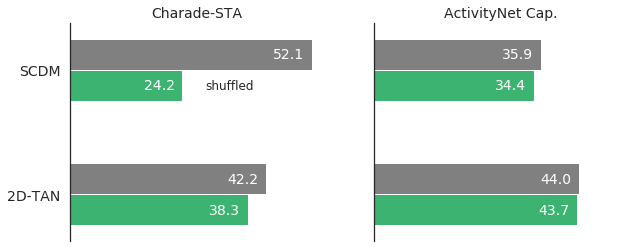

In [25]:
sns.set_style("white")
charade_scores = {
"2D-TAN": charades_2d_tan * 100,
"2D-TAN\n(shuffle)": 38.31,
"SCDM\n(shuffle)": 24.23,
"SCDM": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
}

activitynet_score = {
"2D-TAN": 44.05,
"2D-TAN\n(shuffle)": 43.68,
"SCDM\n(shuffle)": 34.36,
"SCDM": 35.86, # https://arxiv.org/pdf/1910.14303.pdf
}

color_a = "gray"
color_b = "mediumseagreen"

f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pos = np.asarray([.2, .6])
height = 0.1
step = 0.1

done_put_label = False

for ax, score in zip(axes, [charade_scores, activitynet_score]):

    def display_score_h(bar):
        ax.text(
            bar.get_width()-5,
            bar.get_y()+bar.get_height()*.5,
            f"{bar.get_width():.1f}",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=14,
            color="w"
        )

    bars = ax.barh(pos+step,
                    [score["2D-TAN"],
                     score["SCDM"]],
                   height=height,
                   color=color_a
                   )

    for b in bars:
        display_score_h(b)

    bars = ax.barh(pos,
                    [score["2D-TAN\n(shuffle)"], 
                     score["SCDM\n(shuffle)"]],
                   height=height,
                   color=color_b
                   )


    for b in bars:
        display_score_h(b)

    if not done_put_label:
        ax.text(
            b.get_width()+5,
            b.get_y() + b.get_height()*.5,
            "shuffled",
            verticalalignment="center",
            fontsize=12
        )

        done_put_label = True

    ax.set_ylim([0.1, .8])

axes[0].set_title("Charade-STA", loc="center", fontsize=14)
axes[1].set_title("ActivityNet Cap.", loc="center", fontsize=14)

plt.xticks([])
axes[0].tick_params(labelsize=14)
plt.yticks(pos+height*.5, ["2D-TAN", "SCDM"])

sns.despine(bottom=True)
plt.savefig("reports/figures/sanity_check/sanity_check.pdf", bbox_inches="tight")